<a href="https://colab.research.google.com/github/cbadenes/notebooks/blob/main/probabilistic_topic_models/LDA_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook serves as an introduction to **Probabilistic Topic Models**. 

Textual data is loaded from a Google Sheet and topics derived from LDA will be generated. 

First we need to obtain credentials from our Google Account to access the corpus hosted on Google Drive.

In [1]:
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Loading Data

[CORDIS](https://cordis.europa.eu/projects/en) is the primary source of results from EU-funded projects since 1990. 

We used a [sample stored in a spreadsheet](https://goo.gl/dG8eVF) with 100 such projects. Save a copy in your `Google Colab/` folder at Google Drive.

A dataframe will be created from the training google sheet:


In [ ]:
#corpus = 'texts_nlp'
corpus = 'texts'

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open(corpus).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# convert the 3rd column values to a list
documents = [row[2] for row in rows[1:]]
            
# Convert to a DataFrame and render.
import pandas as pd
dataset_df = pd.DataFrame.from_records(rows[1:])
dataset_df.head(n=10)


,0,1,2
0,EU100000,Visual object population codes relating human...,Two major challenges facing systems neuroscien...
1,EU100001,New Opportunities for Research Funding Agency ...,NORFACE is a co-ordinated common action of fif...
2,EU100002,USA and Europe Cooperation in Mini UAVs,Unmanned Aerial Systems have been an active ar...
3,EU100003,Sustainable Infrastructure for Resilient Urban...,This fellowship aim is to identify how the use...
4,EU100004,Modelling star formation in the local universe,The goal of this proposal is to revolutionize ...
5,EU100005,Coherent spin manipulation in hybrid nanostruc...,The rapid development of novel nanoelectronic ...
6,EU100006,Stochastic Modeling of Spatially Extended Ecos...,The coupling between ecosystems and the climat...
7,EU100007,Secure Multiparty Computation in the von Neuma...,The ultimate aim of this project is to design ...
8,EU100008,Infrastructures for Community-Based Data Manag...,"Structured data is increasingly created, trans..."
9,EU100009,Reducing Environmental Footprint based on Mult...,Reduction of CO2 emissions is the great challe...


### Data Cleaning

Now, let`s create the BoWs by using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) facility. 

It is a [ScikitLearn](https://scikit-learn.org/stable/index.html) module focused to create bag-of-words from strings. 


In [ ]:
#stopwords=[]
tf_vectorizer = CountVectorizer(
    stop_words=[],
    min_df=1,
    max_df=1.0,
    lowercase=True,
    max_features=50000,
    token_pattern='[a-zA-Z0-9]{3,}',  
    # num chars > 3,
    analyzer = 'word'
)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
vocab = tf_vectorizer.vocabulary_

print("Vocabulary Size: ", len(tf_feature_names))

Vocabulary Size:  4530


Sorted list of terms by frequency:

In [ ]:
s = tf.toarray().sum(axis=0)
st = sorted(range(len(s)), key=lambda k: s[k], reverse=True)
for i,x in enumerate(st[:20]):
  print(tf_vectorizer.get_feature_names()[x],s[x])

the 1663
and 1204
will 379
for 332
this 191
that 169
with 166
are 149
research 149
project 115
new 99
from 98
systems 95
these 92
data 84
their 82
between 70
which 66
have 64
based 63


### Topic Model

Now it's time to build a LDA-based model by setting values for:
- number of topics
- alpha
- beta

In [ ]:

topics = 3 

alpha = 100.0

beta = 100.0


# Run LDA
lda = LatentDirichletAllocation(
    n_components=topics, 
    doc_topic_prior=alpha, 
    topic_word_prior=beta, 
    max_iter=25, 
    learning_method='online', 
    evaluate_every=1,
    n_jobs = -1,
    random_state=0,
    verbose=1)
lda.fit(tf)


iteration: 1 of max_iter: 25, perplexity: 8237.5363
iteration: 2 of max_iter: 25, perplexity: 4995.8747
iteration: 3 of max_iter: 25, perplexity: 4347.8639
iteration: 4 of max_iter: 25, perplexity: 4103.9597
iteration: 5 of max_iter: 25, perplexity: 3987.0655
iteration: 6 of max_iter: 25, perplexity: 3923.2124
iteration: 7 of max_iter: 25, perplexity: 3885.3072
iteration: 8 of max_iter: 25, perplexity: 3861.4576
iteration: 9 of max_iter: 25, perplexity: 3845.7873
iteration: 10 of max_iter: 25, perplexity: 3835.1376
iteration: 11 of max_iter: 25, perplexity: 3827.7005
iteration: 12 of max_iter: 25, perplexity: 3822.3887
iteration: 13 of max_iter: 25, perplexity: 3818.5220
iteration: 14 of max_iter: 25, perplexity: 3815.6610
iteration: 15 of max_iter: 25, perplexity: 3813.5139
iteration: 16 of max_iter: 25, perplexity: 3811.8820
iteration: 17 of max_iter: 25, perplexity: 3810.6280
iteration: 18 of max_iter: 25, perplexity: 3809.6545
iteration: 19 of max_iter: 25, perplexity: 3808.8919
it

LatentDirichletAllocation(doc_topic_prior=100.0, evaluate_every=1,
                          learning_method='online', max_iter=25, n_components=3,
                          n_jobs=-1, random_state=0, topic_word_prior=100.0,
                          verbose=1)

Explore topics:

In [ ]:
no_top_words = 10
no_top_documents = 5

lda_W = lda.transform(tf)
lda_H = lda.components_

print("LDA Topics")
for topic_idx, topic in enumerate(lda_H):
    print("-"*30)
    print(" Topic ",(topic_idx)," :")
    print("["," | ".join([tf_feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]),"]")
    top_doc_indices = np.argsort( lda_W[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
        row_index = doc_index +1
        print("[",doc_index,"] (",rows[row_index][0],") \'",rows[row_index][1],"\'", [ "{0:.5f}".format(weight) for weight in lda_W[doc_index]])
        

LDA Topics
------------------------------
 Topic  0  :
[ the | and | will | for | this | that | with | research | are | project ]
[ 36 ] ( EU100036 ) ' A network for supporting the coordination of Supercomputing research between Europe and Latin America ' ['0.33708', '0.32855', '0.33437']
[ 59 ] ( EU100061 ) ' Socialism and leftist Catholicism in France and Italy (1956-1972) ' ['0.33591', '0.32958', '0.33451']
[ 28 ] ( EU100028 ) ' Integrated Ground and on-Board system for Support of the Aircraft Safe Take-off and Landing ' ['0.33587', '0.32960', '0.33453']
[ 53 ] ( EU100055 ) ' TOWARDS A JOINT EUROPEAN RESEARCH INFRASTRUCTURE NETWORK FOR COASTAL OBSERVATORIES ' ['0.33574', '0.33008', '0.33418']
[ 34 ] ( EU100034 ) ' Trans-Atlantic Research and Education Agenda in System of Systems ' ['0.33568', '0.32979', '0.33453']
------------------------------
 Topic  1  :
[ the | and | will | for | this | that | with | are | research | project ]
[ 22 ] ( EU100022 ) ' International Partnership for 

### Doc-Topic Matrix


In [ ]:
from IPython.display import display, HTML
import pandas as pd
#pd.set_option('display.max_columns', None)

topicnames = ["topic"+ str(x) for x in range(0, lda.n_components)]

df = pd.DataFrame(lda_W, 
                  columns=topicnames, 
                  index=dataset_df[1].tolist())

display(df)

,topic0,topic1,topic2
Visual object population codes relating human brains to nonhuman and computational models with representational similarity analysis,0.334770,0.331732,0.333497
New Opportunities for Research Funding Agency Co-operation in Europe II,0.335169,0.330534,0.334297
USA and Europe Cooperation in Mini UAVs,0.334761,0.331319,0.333920
Sustainable Infrastructure for Resilient Urban Environments,0.334741,0.331237,0.334022
Modelling star formation in the local universe,0.334148,0.331908,0.333943
...,...,...,...
The Environmental Observation Web and its Service Applications within the Future Internet,0.335226,0.330824,0.333950
Future INternet for Smart ENergY,0.335341,0.329757,0.334902
Smart Food and Agribusiness: Future Internet for Safe and Healthy Food from Farm to Fork,0.335392,0.330743,0.333865
Instant Mobility for Passengers and Goods,0.333904,0.332209,0.333887


### Topic-Word Matrix

In [ ]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis])

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,000,100,146a,1500,1844,192,1993,1mbit,200,2000,2004,2005,2008,2009,2010,2011,2015,2020,2050,20th,270,2nd,30x,400,60s,6th,aberrant,ability,abiotic,ablation,ablations,able,about,above,absolute,absorbed,absorption,abstract,abstraction,academia,...,within,without,withstands,women,word,words,work,workers,workflow,workflows,workforce,working,works,workshops,workstation,world,worldwide,worst,would,wp1,wp2,wp3,wp4,wp5,wp6,writing,www,xmm,year,years,yes,yet,yield,young,younger,youngest,zebrafish,zone,zones,zoo
topic0,0.000218,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000219,0.00022,0.000218,0.000219,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000218,0.000223,0.000218,0.000218,0.000218,0.000227,0.000227,0.000221,0.000218,0.000218,0.000219,0.000219,0.000219,0.000219,...,0.000234,0.000222,0.000218,0.000218,0.000219,0.00022,0.000233,0.000218,0.000218,0.000219,0.000221,0.000219,0.000218,0.000221,0.000219,0.000228,0.000221,0.000218,0.000224,0.000219,0.000219,0.000219,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.00022,0.000227,0.000218,0.000221,0.000219,0.000222,0.000218,0.000218,0.00022,0.000219,0.000218,0.000218
topic1,0.000218,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000219,0.00022,0.000218,0.000219,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000218,0.000223,0.000218,0.000218,0.000218,0.000227,0.000227,0.000221,0.000218,0.000218,0.000219,0.000219,0.000219,0.000219,...,0.000234,0.000222,0.000218,0.000218,0.000219,0.00022,0.000233,0.000218,0.000218,0.000219,0.000222,0.000219,0.000218,0.000221,0.000219,0.000228,0.000222,0.000218,0.000224,0.000219,0.000219,0.000219,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.00022,0.000227,0.000218,0.000221,0.000219,0.000222,0.000218,0.000218,0.00022,0.000219,0.000218,0.000218
topic2,0.000218,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000219,0.00022,0.000218,0.000219,0.000221,0.000218,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.000218,0.000223,0.000218,0.000218,0.000218,0.000227,0.000227,0.000221,0.000218,0.000218,0.000219,0.000219,0.000219,0.000219,...,0.000234,0.000222,0.000218,0.000218,0.000219,0.00022,0.000233,0.000218,0.000218,0.000219,0.000222,0.000219,0.000218,0.000221,0.000219,0.000228,0.000222,0.000218,0.000224,0.000219,0.000219,0.000219,0.000218,0.000218,0.000218,0.000218,0.000219,0.000218,0.00022,0.000227,0.000218,0.000221,0.000219,0.000222,0.000218,0.000218,0.00022,0.000219,0.000218,0.000218


### Top Words per Topic

In [ ]:
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,the,and,will,for,this,that,with,research,are,project
Topic 1,the,and,will,for,this,that,with,are,research,project
Topic 2,the,and,will,for,this,that,with,research,are,project


### Topic Inference

In [ ]:
text = "we develop a project to process models in a large-scale" #@param {type:"string"}

print("Topic Distribution: ", lda.transform(tf_vectorizer.transform([text])))


Topic Distribution:  [[0.33333918 0.33332388 0.33333694]]


### Diagnose model performance

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))

# See model parameters
print(lda)

Log Likelihood:  -183770.06527295607
Perplexity:  3806.659037393167
LatentDirichletAllocation(doc_topic_prior=100.0, evaluate_every=1,
                          learning_method='online', max_iter=25, n_components=3,
                          n_jobs=-1, random_state=0, topic_word_prior=100.0,
                          verbose=1)


Determine the best LDA model:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [5, 10, 15], 'doc_topic_prior': [.1, .3, .5], 'topic_word_prior': [.01, .03, .05]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

Read the best configuration:

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

### Topic-based Documents Clustering

Component's weights: 
 [[ 0.58  0.57  0.58]
 [ 0.54 -0.8   0.26]]
Perc of Variance Explained: 
 [0.   0.91]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

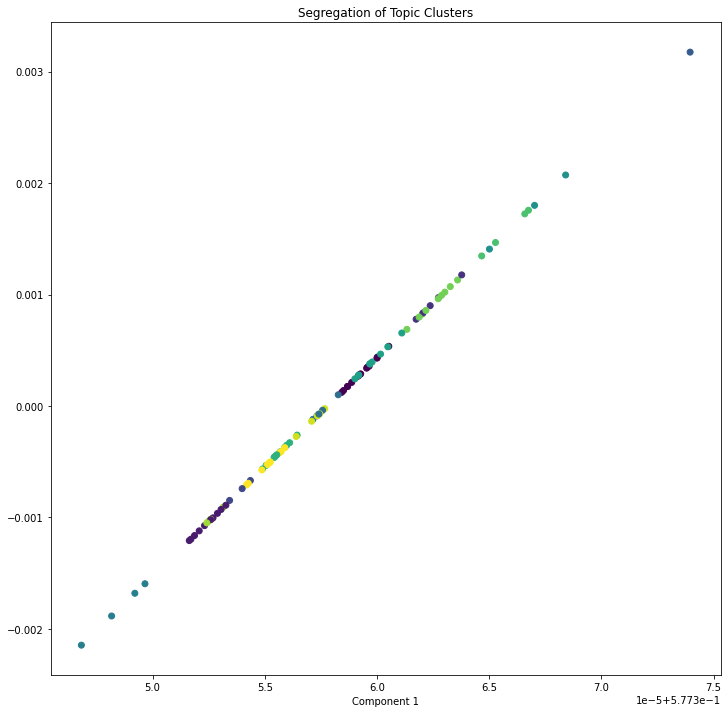

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_W)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_W)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### Topic-based Document Similarity

In [ ]:
# Compute Jensen Shannon Divergence
from scipy.spatial import distance

for i1,d1 in enumerate(lda_W[0:10]):
   for i2,d2 in enumerate(lda_W[0:10]):
      print(rows[i1+1][0], rows[i2+1][0], 1-distance.jensenshannon(d1, d2))

EU100000 EU100000 1.0
EU100000 EU100001 0.9990829622991543
EU100000 EU100002 0.9996373596996787
EU100000 EU100003 0.9995569123512584
EU100000 EU100004 0.9995195507928779
EU100000 EU100005 0.9993904495265891
EU100000 EU100006 0.9991762496356063
EU100000 EU100007 0.999499579470378
EU100000 EU100008 0.9991694951386817
EU100000 EU100009 0.9998170341833871
EU100001 EU100000 0.9990829622991543
EU100001 EU100001 1.0
EU100001 EU100002 0.999410231278026
EU100001 EU100003 0.9994679543688576
EU100001 EU100004 0.998928122429239
EU100001 EU100005 0.9996567064360433
EU100001 EU100006 0.9998825582141756
EU100001 EU100007 0.9989525433554848
EU100001 EU100008 0.9998159454709263
EU100001 EU100009 0.9992342000392059
EU100002 EU100000 0.9996373596996787
EU100002 EU100001 0.999410231278026
EU100002 EU100002 1.0
EU100002 EU100003 0.9999186034091914
EU100002 EU100004 0.9994787055714204
EU100002 EU100005 0.9997437277887763
EU100002 EU100006 0.9995162287469005
EU100002 EU100007 0.9994906788890933
EU100002 EU10

You can tune the `CounterVectorizer` module to clean the input text, or use an already processed corpus. 

Save a copy of this [file](https://goo.gl/RF4cWB) in the `Google Colab/` folder of your Google Drive.